In [94]:
import sys
sys.path.append('../')
import time

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.signal import convolve2d
from scipy.optimize import curve_fit
from scipy.optimize import brute
# import cv2
import torch
import json
import csv
from functions.all_knots_functions import *
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
from sklearn.model_selection import train_test_split
from torch.optim import lr_scheduler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import collections
import itertools
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import trange
import pickle
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torchsummary import summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [95]:
hyperparams = {
    # 'learning_rate': 5e-4,  # Control dropout rate
    'learning_rate': 5e-4,  # Control dropout rate
    'patience': 4,  # Number of epochs between learning rate decay
    'factor': 0.2,  # Multiplicative factor of learning rate decay
    'batch_size': 64
}

num_epochs = 10
print_every = 1


In [96]:
knot_types = {
        'standard_16': 0,  # 1
        'standard_14': 1,  # 2
        'standard_18': 2,  # 3
        '30both': 3,  # 4
        '30oneZ': 4,  # 5
        'optimized': 5,  # 6
        'pm_03_z': 6,  # 7
        # '4foil': hopf_4foil,  # 8
        # '6foil': hopf_6foil,  # 9
        # 'stand4foil': hopf_stand4foil,  # 10
        '30oneX': 7,  # 11
        '15oneZ': 8,
        'dennis': 9,
        'trefoil_standard_12': 10,
        'trefoil_optimized': 11,
        # 'fivefoil_standard_08': fivefoil_standard_08

}


knots = [
    'standard_14', 'standard_16', 'standard_18', '30both', '30oneZ',
    'optimized', 'pm_03_z', '30oneX', '15oneZ', 'dennis',
    'trefoil_standard_12', 'trefoil_optimized'
]


# folders = [
#     '../HOPFS_L270_5e-07_test_1s',
#     '../HOPFS_L270_0.05_1_64x64x64_v1'
# ]
folders = [
    '../HOPFS_L270_0.05_1000_64x64x64_v1',
    '../HOPFS_L270_0.15_1000_64x64x64_v1',
    '../HOPFS_L270_0.25_1000_64x64x64_v1',
]

num_classes = len(knots)
X_list = []
Y_list = []
Xs_list = []
Ys_list = []

csv.field_size_limit(10000000)

# Loop through all folders and knots
for folder in folders:
    for knot in knots:
        filename = f'{folder}/data_{knot}_spectr.csv'
        try:
            with open(filename, 'r') as file:
                reader = csv.reader(file)
                for row in reader:
                    # Append the knot label to Ys_list
                    Ys_list.append(knot_types[knot])

                    # Load the data array from the JSON string
                    data_array = json.loads(row[0])

                    # Extract values from the data array
                    l1, l2 = data_array[0], data_array[1]
                    p1, p2 = data_array[2], data_array[3]

                    # Create and normalize the moments array
                    moments = np.array([x[0] + 1j * x[1] for x in data_array[5:]])
                    moments = moments.reshape((l2 - l1 + 1), (p2 - p1 + 1))
                    moments = moments / np.sqrt(np.sum(np.abs(moments) ** 2))

                    # Append the flattened absolute values to Xs_list
                    Xs_list.append(np.abs(moments.reshape(-1)))

        except FileNotFoundError:
            print(f'File not found: {filename}')
        except json.JSONDecodeError:
            print(f'Error decoding JSON in file: {filename}')

print(f'Loaded {len(X_list)} samples.  {int(len(X_list) / len(knots))} per class')

Loaded 0 samples.  0 per class


In [97]:
Xs_np = np.array(Xs_list)
ys_np = np.array(Ys_list)
# print(ys_np.shape)
Xs_torch = torch.tensor(Xs_np).float()
ys_t = torch.tensor(ys_np)
ys_torch = F.one_hot(ys_t.long(), num_classes=num_classes).float()
print(Xs_torch.shape, ys_torch.shape)

torch.Size([132, 91]) torch.Size([132, 12])


In [98]:
print(Xs_torch[0])

tensor([3.0659e-05, 1.6369e-05, 3.8283e-05, 4.9769e-05, 8.1936e-06, 1.2180e-05,
        3.7773e-05, 6.1330e-06, 3.8164e-06, 2.0567e-05, 1.4556e-05, 1.4410e-05,
        8.5424e-06, 3.4067e-06, 2.2304e-05, 4.0295e-05, 1.5582e-04, 4.6326e-04,
        6.3732e-04, 4.5553e-04, 2.1716e-04, 1.1726e-04, 1.1156e-04, 3.2442e-05,
        1.7654e-05, 1.0925e-06, 1.8934e-06, 1.0405e-05, 1.6589e-04, 1.4999e-04,
        2.8404e-05, 8.8685e-05, 6.0337e-05, 9.9335e-05, 4.5779e-05, 4.8859e-04,
        5.3248e-04, 2.8467e-04, 8.3921e-05, 2.5105e-05, 1.0762e-05, 1.0161e-05,
        2.5991e-01, 6.2465e-01, 4.1949e-01, 1.9545e-04, 2.9676e-04, 6.3974e-04,
        9.5884e-04, 6.6235e-04, 7.6110e-04, 2.9470e-04, 9.2087e-05, 5.6246e-05,
        3.8562e-05, 1.5965e-05, 6.0522e-01, 3.1895e-04, 1.0396e-04, 1.7520e-05,
        8.1342e-05, 9.1863e-05, 8.9024e-05, 6.3937e-04, 2.0127e-04, 7.4561e-05,
        1.9031e-05, 1.4251e-05, 2.5606e-05, 1.6572e-05, 1.4164e-04, 5.1367e-05,
        1.2905e-04, 4.9121e-04, 6.3381e-

In [99]:

train_dataset = TensorDataset(Xs_torch, ys_torch)


In [100]:


# Helper function to create a convolutional stage
def conv_stage_2d(layer_configs):
    layers = []
    for config in layer_configs:
        in_channels, out_channels, kernel_size, stride, padding = config
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding))
        layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU(inplace=True))
    return nn.Sequential(*layers)

# Helper function to create a pooling layer
def create_pooling_layer_2d(config):
    if config is None:
        return None
    kernel_size, stride, padding = config
    return nn.MaxPool2d(kernel_size=kernel_size, stride=stride, padding=padding)

# 2D Convolutional Classifier
class Classifier2D(nn.Module):
    def __init__(self, stages, pooling_configs, num_classes=11, shape_X_l=7, shape_X_p=13):
        super(Classifier2D, self).__init__()

        self.shape_X_l = shape_X_l
        self.shape_X_p = shape_X_p

        self.features = nn.Sequential()

        # Add convolutional stages and pooling layers
        for i, stage in enumerate(stages):
            self.features.add_module(f"stage_{i}", conv_stage_2d(stage))

            # Add MaxPooling layer after each stage based on the pooling configuration
            if i < len(pooling_configs):
                pool_layer = create_pooling_layer_2d(pooling_configs[i])
                if pool_layer:
                    self.features.add_module(f"pool_{i}", pool_layer)

        # Calculate the size of the flattened features after the conv layers
        self._to_linear = None
        self._get_conv_output((1, shape_X_l, shape_X_p))  # Add a channel dimension here

        # Fully connected layers
        self.fc1 = nn.Linear(self._to_linear, 256)
        self.fc2 = nn.Linear(256, num_classes)

    # Helper function to calculate the output size after convolution and pooling
    def _get_conv_output(self, shape):
        batch_size = 1
        input = torch.autograd.Variable(torch.rand(batch_size, *shape))
        output_feat = self.features(input)
        self._to_linear = int(np.prod(output_feat.size()[1:]))

    # Optional: Initialize weights with specific methods
    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    # Forward pass
    def forward(self, x):
        # Reshape input from (batch, shape_X_l * shape_X_p) -> (batch, 1, shape_X_l, shape_X_p)
        batch_size = x.size(0)
        x = x.view(batch_size, 1, self.shape_X_l, self.shape_X_p)  # Add a channel dimension

        # Pass through convolutional layers
        x = self.features(x)

        # Flatten the output
        x = x.view(x.size(0), -1)

        # Pass through fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        return x




In [101]:

stages = [
    # Stage 1: (in_channels, out_channels, kernel_size, stride, padding)
    [(1, 16, 3, 1, 1)],  # First convolution stage with padding
    [(16, 32, 3, 1, 1)],  # Second convolution stage with padding
    [(32, 64, 3, 1, 1)]   # Third convolution stage with padding
]

# Define pooling configurations for each stage (kernel_size, stride, padding)
pooling_configs = [
    (2, 2, 0),  # MaxPool after first stage
    None,        # Skip pooling after the second stage
    (2, 2, 0)   # MaxPool after the third stage
]
stages = [
    [(1, 32, 3, 1, 1), (32, 32, 3, 1, 1), (32, 32, 3, 1, 1)],
    [(32, 64, 5, 1, 1), (64, 64, 5, 1, 1), (64, 64, 5, 1, 1)]
]
stages = [
    [(1, 32, 3, 1, 1), (32, 32, 3, 1, 1), (32, 32, 3, 1, 1)],
    [(32, 64, 3, 1, 1), (64, 64, 3, 1, 1), (64, 64, 3, 1, 1)]
]
# Define pooling configurations: (kernel_size, stride, padding)
# Set to 'None' for stages where no pooling is desired
# kernel_size, stride, padding
pooling_configs = [
    (2, 2, 1),  # Pooling after the first stage
    (2, 2, 1)      # No pooling after the third stage
]
# Example usage
shape_X_l = 7  # Modify as needed
shape_X_p = 13  # Modify as needed
num_classes = ys_torch.shape[-1]

# Initialize the model
model = Classifier2D(stages, pooling_configs, num_classes, shape_X_l, shape_X_p).to(device)

print(model)

Classifier2D(
  (features): Sequential(
    (stage_0): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
    )
    (pool_0): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (stage_1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64

In [102]:
# print(model._to_linear, 512 * 16 * 16)
dots_3d_toch_batch = train_dataset[1:4][0].to(device)
print(dots_3d_toch_batch.shape)
print(model(dots_3d_toch_batch).shape)
summary(model, input_size=dots_3d_toch_batch.shape[1:])

torch.Size([3, 91])
torch.Size([3, 12])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 32, 7, 13]             320
       BatchNorm2d-2            [-1, 32, 7, 13]              64
              ReLU-3            [-1, 32, 7, 13]               0
            Conv2d-4            [-1, 32, 7, 13]           9,248
       BatchNorm2d-5            [-1, 32, 7, 13]              64
              ReLU-6            [-1, 32, 7, 13]               0
            Conv2d-7            [-1, 32, 7, 13]           9,248
       BatchNorm2d-8            [-1, 32, 7, 13]              64
              ReLU-9            [-1, 32, 7, 13]               0
        MaxPool2d-10             [-1, 32, 4, 7]               0
           Conv2d-11             [-1, 64, 4, 7]          18,496
      BatchNorm2d-12             [-1, 64, 4, 7]             128
             ReLU-13             [-1, 64, 4, 7]               0

In [103]:
train_dataset[1:2][0]

tensor([[4.6387e-05, 2.2017e-05, 4.1045e-05, 4.3364e-05, 2.6819e-05, 3.5398e-05,
         2.6810e-05, 4.1336e-05, 3.5944e-05, 1.1803e-06, 1.3765e-05, 6.1735e-06,
         1.2568e-05, 1.6452e-05, 8.3469e-05, 2.6047e-05, 1.8260e-04, 4.5117e-04,
         6.4492e-04, 4.3694e-04, 2.0579e-04, 9.1498e-05, 5.6196e-05, 3.7990e-05,
         2.1209e-05, 1.0520e-05, 1.6337e-05, 1.2209e-05, 1.2364e-04, 1.1329e-04,
         1.0256e-04, 2.9390e-05, 5.8968e-05, 9.2591e-05, 5.9887e-05, 3.1635e-04,
         4.6738e-04, 3.3220e-04, 8.1445e-05, 2.7949e-05, 3.5306e-05, 2.0466e-05,
         2.6292e-01, 6.3216e-01, 4.2105e-01, 1.3459e-04, 2.7177e-04, 7.0652e-04,
         9.1455e-04, 3.5986e-04, 6.0580e-04, 2.9552e-04, 9.4468e-05, 3.5680e-05,
         3.4238e-05, 1.9145e-05, 5.9494e-01, 1.6821e-04, 5.5187e-05, 6.0124e-05,
         6.0842e-05, 1.0935e-04, 7.2665e-05, 3.9111e-04, 7.7478e-05, 1.1014e-04,
         4.2463e-05, 1.5377e-05, 6.1185e-06, 8.5051e-06, 1.0105e-04, 5.5363e-05,
         1.6382e-04, 4.4759e

In [104]:
def loop_train(model, train_loader, criterion, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0
    for i, (inputs, targets) in enumerate(train_loader, 1):  # Start enumeration from 1
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()  # Clear the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, targets)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights
        total_loss += loss.item()  # Accumulate the loss

    return total_loss / len(train_loader)  # Return the average loss


def loop_test(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    with torch.no_grad():  # No need to track the gradients
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, targets)  # Compute the loss
            total_loss += loss.item()  # Accumulate the loss
    return total_loss / len(test_loader)  # Return the average loss


def correct_number_test(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_correct = 0
    total = 0
    with torch.no_grad():  # No need to track the gradients
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)  # Forward pass
            correct = criterion(outputs, targets)  # Compute correct
            total_correct += correct  # Accumulate correct
            total += len(outputs)  # Accumulate total
    return total_correct, total  # Return the average loss


def plot_losses(train_losses, test_losses, decimals=3):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses,
             label=f'Train Loss {train_losses[-1]: .{decimals}f} (min: {min(train_losses): .{decimals}f})')
    plt.plot(test_losses, label=f'Test Loss {test_losses[-1]: .{decimals}f} (min: {min(test_losses): .{decimals}f})')
    plt.title('Training and Testing Losses Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [105]:

# criterion = nn.MSELoss().to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=hyperparams['learning_rate'])
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=hyperparams['factor'], patience=hyperparams['patience'],
                              verbose=True)



train_losses = []
val_losses = []
train_loader = DataLoader(train_dataset, batch_size=hyperparams['batch_size'], shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=hyperparams['batch_size'])
# test_loader = DataLoader(test_dataset, batch_size=hyperparams['batch_size'])
start_time = time.time()
for epoch in trange(num_epochs, desc="Progress"):
    epoch_start_time = time.time()
    train_losses.append(loop_train(model, train_loader, criterion, optimizer))
    val_losses.append(0)

    scheduler.step(val_losses[-1])

    if (epoch + 1) % print_every == 0:
        epoch_time = time.time() - epoch_start_time
        print(f'Epoch {epoch} completed in {epoch_time:.2f} seconds')
        print(f'Epoch {epoch}: Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')


total_training_time = time.time() - start_time
print(f'Total training time: {total_training_time:.2f} seconds')

Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0 completed in 0.02 seconds
Epoch 0: Train Loss: 2.4575, Val Loss: 2.4900
Epoch 1 completed in 0.01 seconds
Epoch 1: Train Loss: 2.1887, Val Loss: 2.4914
Epoch 2 completed in 0.02 seconds
Epoch 2: Train Loss: 1.9258, Val Loss: 2.4907
Epoch 3 completed in 0.02 seconds
Epoch 3: Train Loss: 1.7632, Val Loss: 2.4884
Epoch 4 completed in 0.02 seconds
Epoch 4: Train Loss: 1.4723, Val Loss: 2.4846
Epoch 5 completed in 0.02 seconds
Epoch 5: Train Loss: 1.2685, Val Loss: 2.4841
Epoch 6 completed in 0.02 seconds
Epoch 6: Train Loss: 1.0624, Val Loss: 2.4850


Progress:  70%|███████   | 7/10 [00:00<00:00, 63.58it/s]

Epoch 7 completed in 0.02 seconds
Epoch 7: Train Loss: 0.9164, Val Loss: 2.4851
Epoch 8 completed in 0.02 seconds
Epoch 8: Train Loss: 0.7536, Val Loss: 2.4858
Epoch 9 completed in 0.01 seconds
Epoch 9: Train Loss: 0.6373, Val Loss: 2.4838


Progress: 100%|██████████| 10/10 [00:00<00:00, 63.43it/s]

Total training time: 0.16 seconds


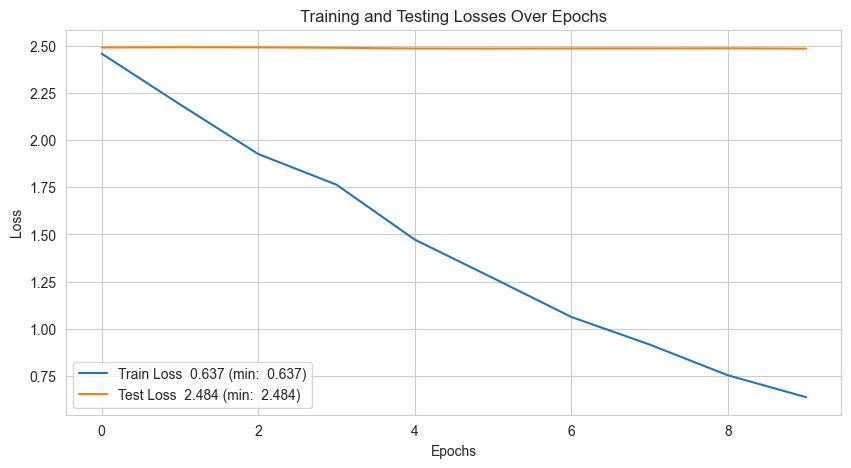

In [106]:
plot_losses(train_losses, val_losses, decimals=3)

In [109]:
# Save the model state (weights) and structure
model_save_path = "classifier2d_full.pth"

torch.save({
    'model_state_dict': model.state_dict(),
    'hyperparams': hyperparams,
    'num_classes': num_classes,
    'stages': stages,
    'pooling_configs': pooling_configs,
}, model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to classifier2d.pth
